In [48]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from datetime import timedelta

Enter the keyword:  cards


C:\Users\Arpan Basu Sachdeva\anaconda3\envs\AI\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


            cards  isPartial
date                        
2020-12-20    100      False
2019-12-15     98      False
2021-12-19     97      False
2019-12-22     94      False
2019-12-08     93      False
...           ...        ...
2023-09-17     57      False
2023-05-21     56      False
2023-07-02     56      False
2021-05-23     55      False
2021-09-05     55      False

[262 rows x 2 columns]


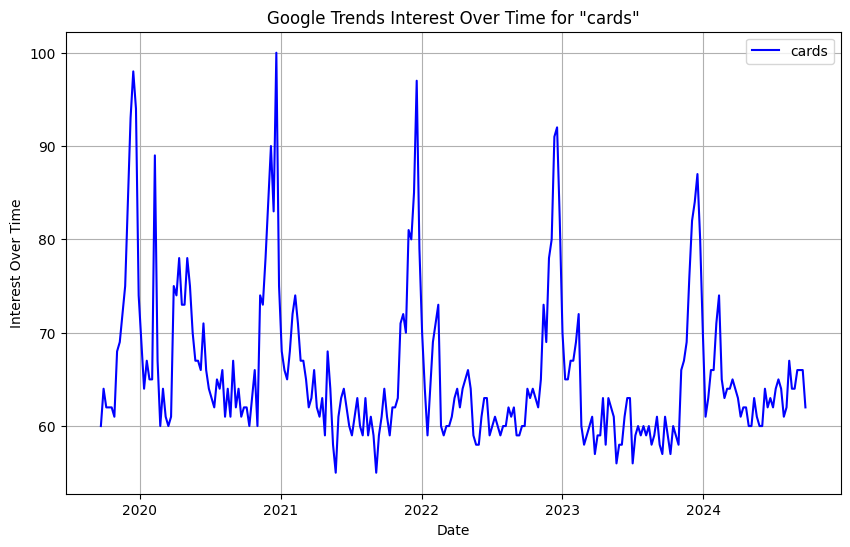

In [49]:

# Initialize the TrendReq object
trend_request = TrendReq()

# Build the payload with the user-provided keyword
search = input("Enter the keyword: ")
trend_request.build_payload(kw_list=[search])

# Retrieve the interest over time data
data_time = trend_request.interest_over_time()

# Check if the search term exists in the data (Google Trends sometimes returns empty dataframes)
if not data_time.empty and search in data_time.columns:
    # Optionally handle object dtypes here
    data_time = data_time.infer_objects()
    # Convert the DataFrame to a NumPy array
    array_data = data_time[[search]].reset_index().values.tolist()
    
    # Print the sorted data
    print(data_time.sort_values(by=search, ascending=False))
    
    # Plotting the interest over time
    plt.figure(figsize=(10, 6))
    plt.plot(data_time.index, data_time[search], label=search, color='blue')
    plt.xlabel('Date')
    plt.ylabel('Interest Over Time')
    plt.title(f'Google Trends Interest Over Time for "{search}"')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"No data found for the keyword: {search}")


                          cards
geoName                        
United Kingdom              100
United States                97
Ireland                      83
Australia                    82
Canada                       77
...                         ...
Guyana                        0
Haiti                         0
Heard & McDonald Islands      0
Honduras                      0
Åland Islands                 0

[250 rows x 1 columns]


<Axes: xlabel='geoName'>

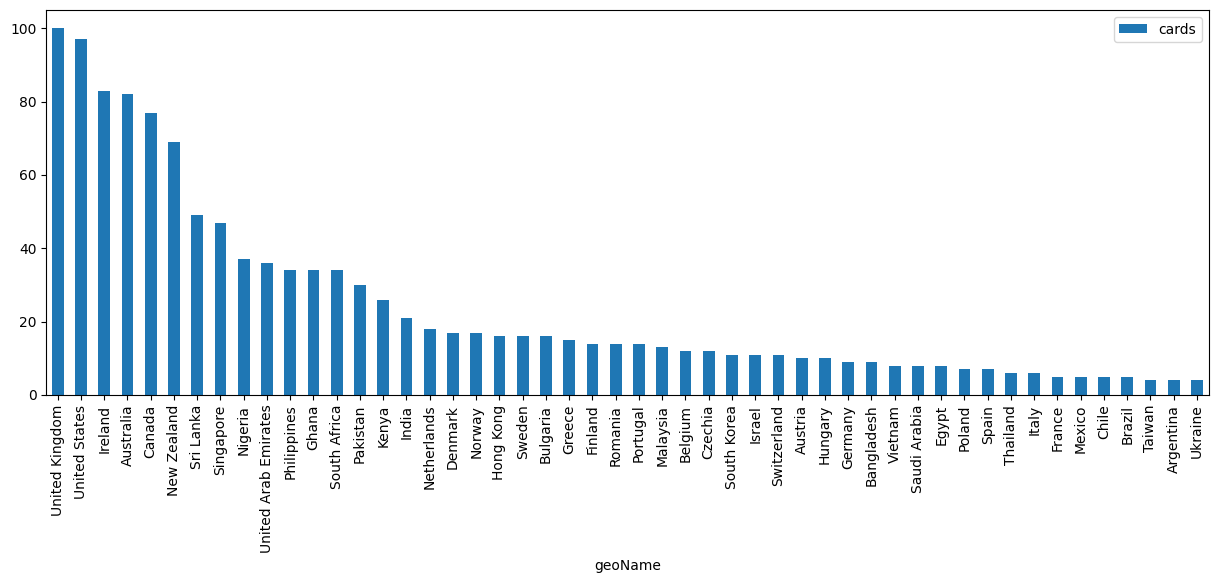

In [50]:
data_region = trend_request.interest_by_region()
data_region = data_region.sort_values(by=search, ascending = False)
print(data_region)
data_region = data_region.head(50)
data_region.reset_index().plot(x="geoName", y=f"{search}", figsize=(15,5), kind="bar")

In [51]:
varr = []
for i in range(len(array_data)):
    varr.append(torch.tensor(array_data[i][1]))
x, y = [], []
for i in varr:
    c = 1
    x.append(varr[:3])
    varr = varr[c:]
    c+=1
    y.append(varr[3])
    if len(varr)==4:
        break
varr = []
for i in range(len(array_data)):
    varr.append(torch.tensor(array_data[i][1]))
x, y = [], []
for i in varr:
    c = 1
    x.append(varr[:3])
    varr = varr[c:]
    c+=1
    y.append(varr[3])
    if len(varr)==4:
        break
x = torch.tensor(x, dtype=torch.float32)  # Inputs should be float32 for the model
y = torch.tensor(y, dtype=torch.long)     # Outputs (targets) should be long for classification
x, y

(tensor([[ 60.,  64.,  62.],
         [ 64.,  62.,  62.],
         [ 62.,  62.,  62.],
         [ 62.,  62.,  61.],
         [ 62.,  61.,  68.],
         [ 61.,  68.,  69.],
         [ 68.,  69.,  72.],
         [ 69.,  72.,  75.],
         [ 72.,  75.,  84.],
         [ 75.,  84.,  93.],
         [ 84.,  93.,  98.],
         [ 93.,  98.,  94.],
         [ 98.,  94.,  74.],
         [ 94.,  74.,  69.],
         [ 74.,  69.,  64.],
         [ 69.,  64.,  67.],
         [ 64.,  67.,  65.],
         [ 67.,  65.,  65.],
         [ 65.,  65.,  89.],
         [ 65.,  89.,  67.],
         [ 89.,  67.,  60.],
         [ 67.,  60.,  64.],
         [ 60.,  64.,  61.],
         [ 64.,  61.,  60.],
         [ 61.,  60.,  61.],
         [ 60.,  61.,  75.],
         [ 61.,  75.,  74.],
         [ 75.,  74.,  78.],
         [ 74.,  78.,  73.],
         [ 78.,  73.,  73.],
         [ 73.,  73.,  78.],
         [ 73.,  78.,  75.],
         [ 78.,  75.,  70.],
         [ 75.,  70.,  67.],
         [ 70.

In [52]:
class LSTMNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer to map from hidden state space to output space
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Determine if input is batched
        if x.dim() == 2:  # Unbatched input (single sequence)
            x = x.unsqueeze(0)  # Add a batch dimension

        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get the last time step's hidden state
        out = out[:, -1, :]  # Take the output at the last time step
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out


# Hyperparameters
input_size = 3  # Since we're using a sequence of 3 categorical numbers as input
hidden_size = 4096
output_size = torch.max(y).item() + 1
num_layers = 2
learning_rate = 0.001
num_epochs = 1000


In [53]:
# Initialize model, loss function, optimizer
model = LSTMNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()  # For classification problems
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [54]:
x = x.view(258, -1, input_size)  # Adjust based on your input dimensions

# Model forward pass and loss calculation
outputs = model(x)  # Should return outputs with shape (258, output_size)
loss = criterion(outputs, y)  # Ensure the shapes are compatible

# Check the shapes to debug
print(f"Outputs shape: {outputs.shape}, Targets shape: {y.shape}")

# Continue with backward pass and optimization
optimizer.zero_grad()
loss.backward()
optimizer.step()


Outputs shape: torch.Size([258, 101]), Targets shape: torch.Size([258])


In [55]:
# Training Loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [10/1000], Loss: 3.1376
Epoch [20/1000], Loss: 3.0411
Epoch [30/1000], Loss: 2.8747
Epoch [40/1000], Loss: 2.7378
Epoch [50/1000], Loss: 2.6369
Epoch [60/1000], Loss: 2.5292
Epoch [70/1000], Loss: 2.4399
Epoch [80/1000], Loss: 2.4323
Epoch [90/1000], Loss: 2.2656
Epoch [100/1000], Loss: 2.1773
Epoch [110/1000], Loss: 2.1501
Epoch [120/1000], Loss: 2.0363
Epoch [130/1000], Loss: 2.0018
Epoch [140/1000], Loss: 1.9346
Epoch [150/1000], Loss: 1.8390
Epoch [160/1000], Loss: 1.7530
Epoch [170/1000], Loss: 2.0663
Epoch [180/1000], Loss: 1.7897
Epoch [190/1000], Loss: 1.6021
Epoch [200/1000], Loss: 1.5556
Epoch [210/1000], Loss: 1.5268
Epoch [220/1000], Loss: 1.5320
Epoch [230/1000], Loss: 1.4223
Epoch [240/1000], Loss: 1.5354
Epoch [250/1000], Loss: 1.4244
Epoch [260/1000], Loss: 1.4359
Epoch [270/1000], Loss: 1.3968
Epoch [280/1000], Loss: 1.3684
Epoch [290/1000], Loss: 1.2812
Epoch [300/1000], Loss: 1.4202
Epoch [310/1000], Loss: 1.2281
Epoch [320/1000], Loss: 1.1921
Epoch [330/1000],

In [56]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Get predictions for all inputs (x)
    predictions = model(x)
    
    # Convert the raw output (logits) to predicted classes using argmax
    predicted_classes = torch.argmax(predictions, dim=1)
    
    # Print all predicted values
    print("Predicted classes for the dataset:")
    print(predicted_classes)

    # Optionally, print the actual labels for comparison
    print("Actual labels:")
    print(y)
predicted_classes.shape, y.shape

Predicted classes for the dataset:
tensor([ 62,  64,  68,  69,  72,  75,  84,  93,  98,  94,  74,  69,  64,  67,
         65,  65,  89,  67,  60,  64,  61,  60,  61,  75,  59,  78,  73,  73,
         78,  75,  70,  67,  67,  66,  71,  66,  64,  63,  62,  65,  73,  66,
         61,  64,  61,  67,  62,  64,  61,  62,  62,  60,  60,  63,  60,  74,
         73,  78,  84,  90,  83, 100,  75,  68,  66,  65,  68,  72,  74,  71,
         67,  67,  65,  62,  63,  66,  62,  61,  63,  59,  68,  64,  58,  55,
         61,  63,  64,  62,  64,  65,  61,  63,  60,  59,  63,  59,  61,  59,
         55,  59,  61,  64,  61,  59,  62,  62,  63,  71,  72,  70,  81,  80,
         85,  97,  79,  70,  64,  59,  64,  69,  71,  73,  60,  59,  60,  60,
         59,  63,  64,  62,  64,  65,  66,  64,  59,  58,  58,  61,  63,  63,
         59,  60,  61,  60,  59,  59,  60,  59,  63,  62,  59,  62,  60,  60,
         64,  63,  63,  63,  62,  65,  73,  66,  78,  80,  91,  92,  82,  70,
         65,  65,  67,  67,  

(torch.Size([258]), torch.Size([258]))

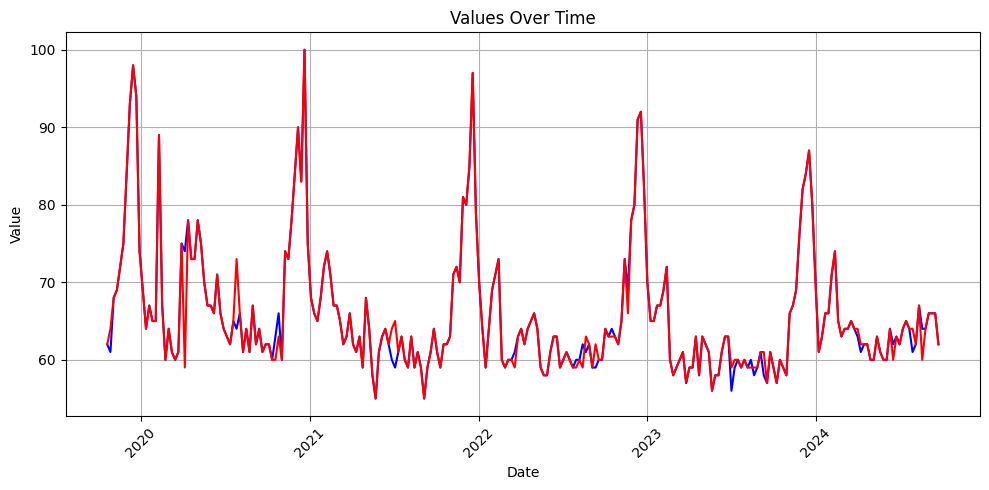

In [57]:
# Extracting dates and values
prediction_array = array_data[4:]
dates = [item[0] for item in prediction_array]
v1 = [item[1] for item in prediction_array]
v2 = [item for item in predicted_classes]
# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(dates, v1, linestyle='-', color='b')
plt.plot(dates, v2, linestyle='-', color='r')
plt.title('Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

In [58]:

# Assuming predicted_classes and actual classes (y) are defined

def calculate_accuracy(predicted_classes, actual_classes):
    correct_predictions = torch.sum(predicted_classes == actual_classes)
    accuracy = correct_predictions.item() / len(actual_classes)
    return accuracy

# Calculate accuracy
accuracy = calculate_accuracy(predicted_classes, y)
print("Accuracy:", accuracy * 100, "%")


Accuracy: 90.69767441860465 %


In [113]:
import torch
import random

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Get predictions for all inputs (x)
    predictions = model(x)
    
    # Convert the raw output (logits) to predicted classes using argmax
    predicted_classes = torch.argmax(predictions, dim=1)
    
    # Initialize future prediction list with the last 3 predicted classes
    future_predictions = predicted_classes[-3:].tolist()
    
    # Predict the next 104 values
    for i in range(104):
        # Convert the last 3 predicted values into a tensor for input
        input_tensor = torch.tensor([future_predictions[-3:]], dtype=torch.float32)
        
        # Predict the next value using the model
        next_prediction = model(input_tensor)
        
        # Convert logits to class prediction
        next_class = torch.argmax(next_prediction).item()
        
        # Randomly add 0, -1, 1, -2, or 2 to the predicted class
        noise = random.choice([0, -1, 1, -2])
        next_class += noise
        
        # Append the predicted class to the future_predictions list
        future_predictions.append(next_class)
        
    # Print all future predictions
    print("Future predicted values:")
    print(future_predictions[2:])  # Only show the first 104 future values
len(future_predictions[2:])

Future predicted values:
[62, 65, 65, 72, 70, 78, 91, 92, 71, 62, 61, 62, 62, 61, 68, 71, 74, 92, 61, 64, 68, 72, 63, 63, 65, 67, 60, 74, 76, 72, 65, 64, 69, 63, 62, 60, 61, 58, 60, 56, 58, 61, 58, 60, 57, 62, 62, 57, 62, 61, 57, 59, 64, 62, 57, 56, 61, 58, 58, 58, 61, 63, 59, 63, 62, 61, 56, 57, 60, 58, 61, 59, 58, 61, 61, 69, 68, 74, 65, 65, 65, 60, 59, 60, 58, 60, 57, 59, 56, 62, 65, 63, 61, 62, 59, 60, 60, 61, 64, 57, 71, 78, 88, 95, 93]


105

In [114]:
# Extract timestamps from array_data
timestamps = [item[0] for item in array_data]

# Calculate the interval between timestamps (assuming regular intervals)
interval = timestamps[1] - timestamps[0]

# Generate more timestamps with the same interval
n = 104  # Number of additional timestamps to generate
last_timestamp = timestamps[-1]
new_timestamps = []
new_timestamps.append(last_timestamp)
for _ in range(n):
    next_timestamp = last_timestamp + interval
    new_timestamps.append(next_timestamp)
    last_timestamp = next_timestamp

len(new_timestamps)

105

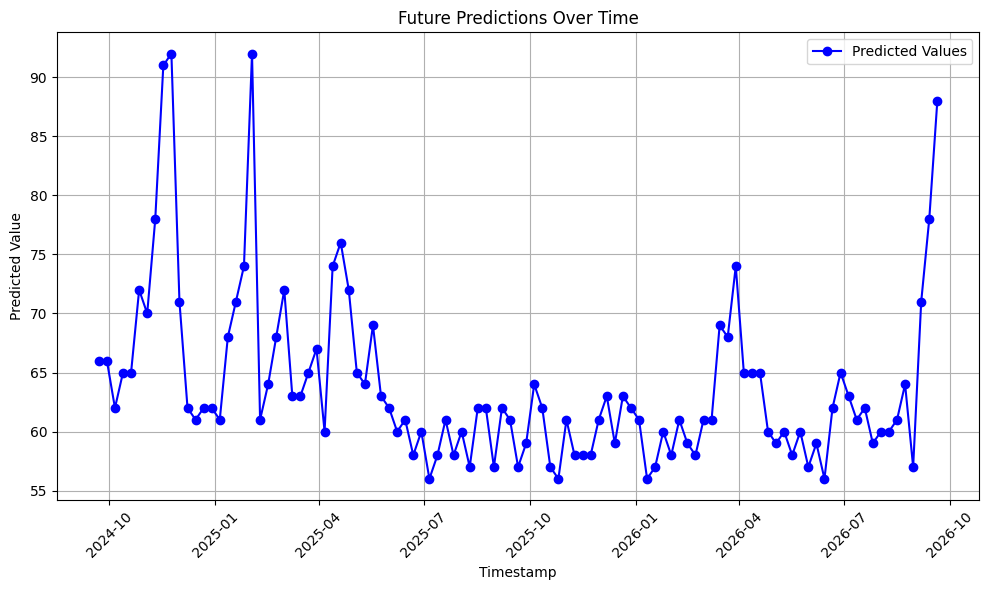

In [115]:
# Plot the predictions with timestamps
plt.figure(figsize=(10, 6))
plt.plot(new_timestamps, future_predictions[:105], marker='o', linestyle='-', color='b', label='Predicted Values')

# Formatting the plot
plt.xlabel('Timestamp')
plt.ylabel('Predicted Value')
plt.title('Future Predictions Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

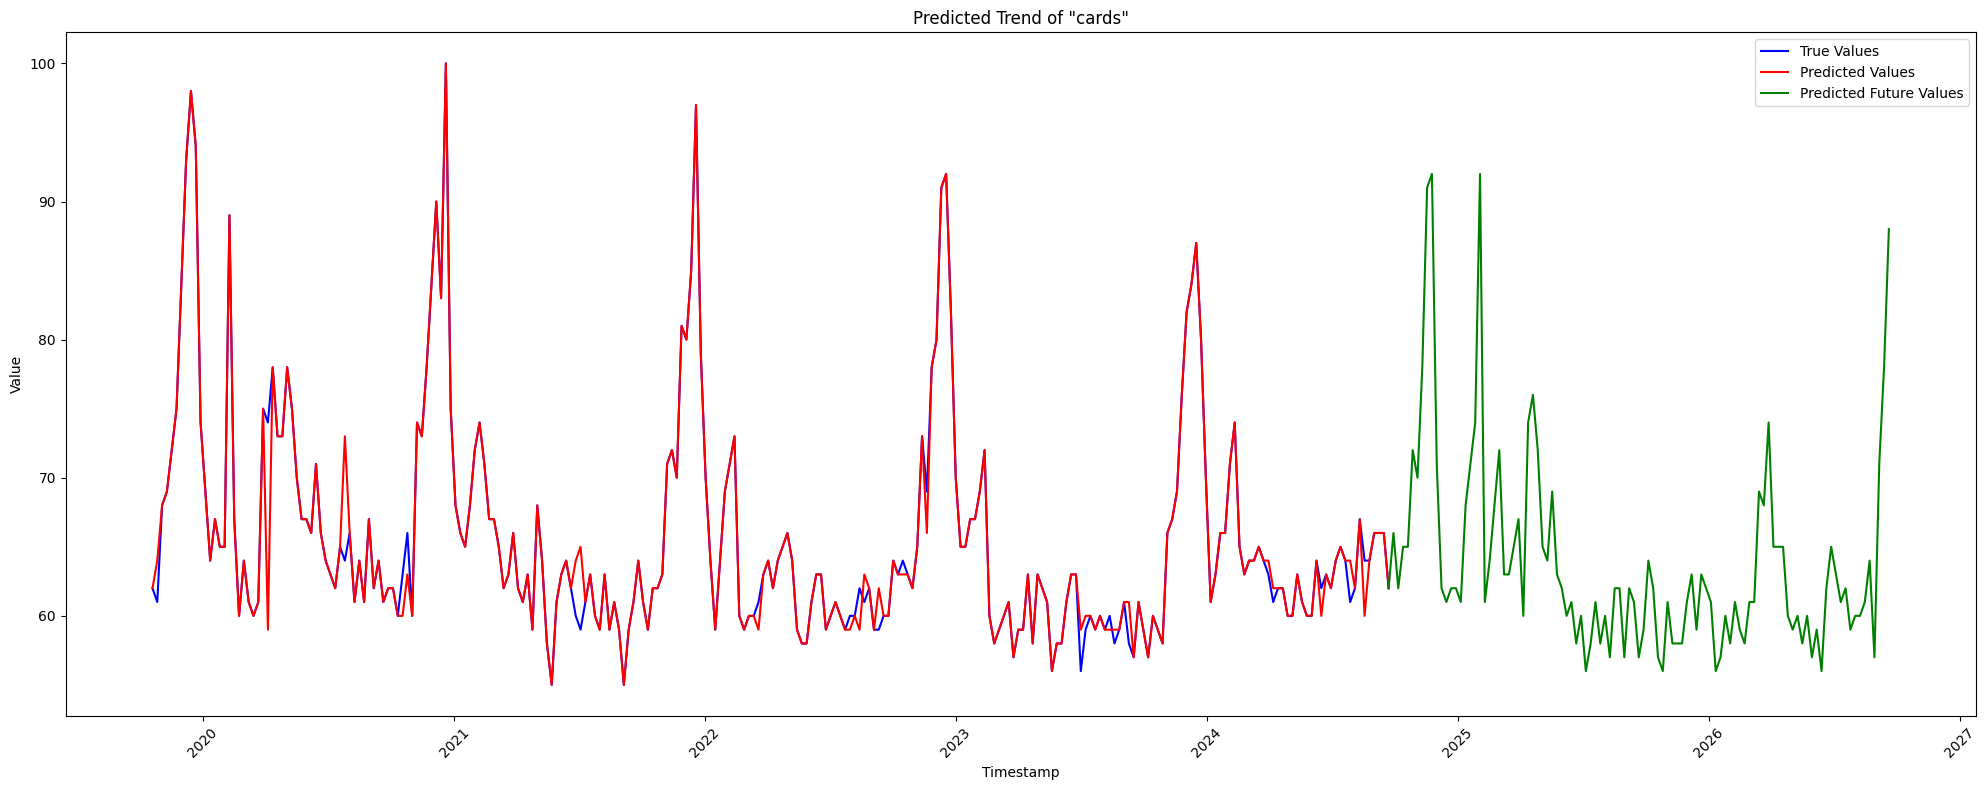

In [116]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(20, 8))

# Plot true values
plt.plot(dates, v1, linestyle='-', color='b', label='True Values')

# Plot predicted values
plt.plot(dates, v2, linestyle='-', color='r', label='Predicted Values')

# Ensure future_predictions starts from the last value of v2
# Adjust the first value of future_predictions if needed
if future_predictions[0] != v2[-1]:
    future_predictions[0] += (v2[-1] - future_predictions[0])

# Plot future predicted values
plt.plot(new_timestamps, future_predictions[:105], color='green', label='Predicted Future Values')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title(f'Predicted Trend of "{search}"')

# Add a legend
plt.legend()

# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
